In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from pandas_summary import DataFrameSummary
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt

F:\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = 'data/bulldozers/'

In [4]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                 parse_dates=["saledate"])

In [5]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 
                           'display.max_columns', 1000):
        display(df)       
    

In [6]:
display_all(df_raw.head().T)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [7]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# need the log of sale price
df_raw.SalePrice = np.log(df_raw.SalePrice)
df_raw.SalePrice

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
5         10.184900
6          9.952278
7         10.203592
8          9.975808
9         11.082143
10        10.085809
11        10.021271
12        10.491274
13        10.325482
14        10.239960
15         9.852194
16         9.510445
17         9.159047
18         9.433484
19         9.350102
20        10.621327
21        10.448715
22        10.165852
23        11.198215
24        10.404263
25         9.433484
26         9.648595
27        10.878047
28        10.736397
29        11.396392
            ...    
401095     9.259131
401096     9.210340
401097     9.047821
401098     9.259131
401099     9.305651
401100     9.259131
401101     9.210340
401102     9.259131
401103     9.433484
401104     9.259131
401105     9.210340
401106     9.259131
401107     9.433484
401108     9.259131
401109     9.259131
401110     9.259131
401111     9.210340
401112     9.259131
401113     9.259131


In [9]:
# function to define expansion of date time into columns for year, month, week etc.

def add_date_info(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
    
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    # attributes to add to dataframe
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 
            'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    # add time attributes if time=True
    if time:
        attr = attr + ['Hour', 'Minute', 'Second']
    # add datetime attributes to the dataframe
    for n in attr:
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10**9
    
    # drop the original date column if drop=True
    if drop:
        df.drop(fldname, axis=1, inplace=True)   
        

In [10]:
add_date_info(df_raw, 'saledate')

In [11]:
display_all(df_raw.head().T)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,11.0974,10.9508,9.21034,10.5584,9.30565
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
fiModelDesc,521D,950FII,226,PC120-6E,S175


The categorical variables are all currently strings, which is not very efficient. The following function converts them to pandas categories.

In [12]:
def convert_cats(df):
    for i, j in df.items():
        if pd.api.types.is_string_dtype(j):
            df[i] = j.astype('category').cat.as_ordered()

In [13]:
convert_cats(df_raw)

In [14]:
#os.makedirs('tmp1', exist_ok=True)

In [15]:
#df_raw.to_feather('tmp/bulldozers-rawx')

In [4]:
df_raw = pd.read_feather('tmp/bulldozers-rawx')

C:\Users\SamJenks\AppData\Roaming\Python\Python36\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [5]:
def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col) # sets boolean to na's in col and adds to df
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict
    

In [6]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and (max_n_cat == None or col.nunique() > max_n_cat):
        df[name] = col.cat.codes + 1
    

In [7]:
def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [8]:
# fast ai's proc_df function to split off response variable and change df to entirely numeric
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: 
        ignore_flds=[]
    if not skip_flds: 
        skip_flds=[]
    if subset: 
        df = get_sample(df,subset)
    else: 
        df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: 
        preproc_fn(df)
    if y_fld is None:
        y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: 
        na_dict = {}
    else: 
        na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): 
        na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: 
        mapper = scale_vars(df, mapper)
    for n,c in df.items(): 
        numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: 
        res = res + [mapper]
    return res

In [9]:
df, y, nas = proc_df(df_raw, 'SalePrice')

Time to split into training and validation sets

In [10]:
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy() #split dataset     

In [11]:
n_valid = 12000 # kaggle's test set size
n_trn = len(df) - n_valid
train_raw, valid_raw = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [12]:
X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [13]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

def print_score(model):
    res = [rmse(model.predict(X_train), y_train), rmse(model.predict(X_valid), y_valid),
          model.score(X_train, y_train), model.score(X_valid, y_valid)]
    if hasattr(model, 'oob_score_'):
        res.append(model.oob_score_)
    print("RMSE Train:", res[0], "RMSE Valid:", res[1], 
         "R2 Train:", res[2], "R2 Valid:", res[3])
    if hasattr(model, 'oob_score_'):
        print("OOB_Score:", res[4])

In [28]:
model = RandomForestRegressor(n_jobs=-1)
%time model.fit(X_train, y_train)
print_score(model)

Wall time: 26.8 s
RMSE Train: 0.09060154265611996 RMSE Valid: 0.25207385968456186 R2 Train: 0.9828443960813568 R2 Valid: 0.8865241103085297


AttributeError: 'RandomForestRegressor' object has no attribute 'oob_score_'

In [14]:
df_train, y_train, nas = proc_df(df_raw, 'SalePrice', subset=30000)

In [15]:
X_train, _ = split_vals(df_train, n=20000)
y_train, _ = split_vals(y_train, n=20000)

In [16]:
X_train.shape, y_train.shape

((20000, 66), (20000,))

In [33]:
model = RandomForestRegressor(n_jobs=-1)
%time model.fit(X_train, y_train)
print_score(model)

Wall time: 1.07 s
RMSE Train: 0.11506965743402424 RMSE Valid: 0.36355582826775096 R2 Train: 0.9711299933159089 R2 Valid: 0.7639575049364641


## Bagging

Let's grab the prediction for each individual tree and view a single example

In [34]:
predictions = np.stack([tree.predict(X_valid) for tree in model.estimators_])

predictions[:,0], np.mean(predictions[:,0]), y_valid[0]

(array([ 9.39266193,  9.15904708,  9.15904708,  9.04782144, 10.23995979,
         9.21034037,  9.10497986,  9.39266193,  9.21034037,  9.15904708]),
 9.307590692221265,
 9.104979856318357)

In [35]:
predictions.shape 
# 10 trees, 12000 rows therefore 10 predictions from 10 trees for each row

(10, 12000)

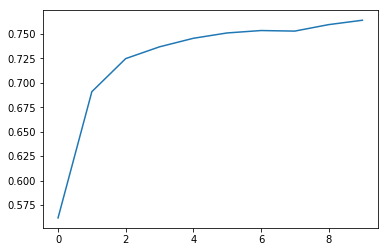

In [36]:
# take the r2 score of y_valid against the mean of the 10 trees
plt.plot([metrics.r2_score(y_valid, np.mean(predictions[:i+1], axis=0)) for i in range(10)])

Doesn't look like more trees will help from looking at the above graph

In [37]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

RMSE Train: 0.09415616761345612 RMSE Valid: 0.3421958789536283 R2 Train: 0.9806704033930675 R2 Valid: 0.7908790591845957


## Out of bag score

In [17]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
model.fit(X_train,y_train)
print_score(model)

RMSE Train: 0.09259872121059758 RMSE Valid: 0.3332310082577277 R2 Train: 0.9814646048620088 R2 Valid: 0.8016926603811113
OOB_Score: 0.864543993024239


If oob score is higher than validation score, it is a sign of overfitting. Also need to take into consideration the time sensitive nature of the data.

In [21]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [30]:
def set_rf_samples(n):
    """Changes scikit learn's random forests giving each tree a random sample of n random rows
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
                                      forest.check_random_state(rs).randint(0, n_samples, n))
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
                                    forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [31]:
set_rf_samples(20000)

In [32]:
model = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time model.fit(X_train, y_train)
print_score(model)

Wall time: 4.94 s
RMSE Train: 0.24091551354888144 RMSE Valid: 0.27772970588807444 R2 Train: 0.8786990059367328 R2 Valid: 0.8622496717316721
OOB_Score: 0.8660076211852319


In [33]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time model.fit(X_train, y_train)
print_score(model)

Wall time: 14.4 s
RMSE Train: 0.2270038154287833 RMSE Valid: 0.26522623006044277 R2 Train: 0.8923036115570572 R2 Valid: 0.8743735988868608
OOB_Score: 0.8807794564410351


Rather than limit the total amount of data that our model can access, let's instead limit it to a different random subset per tree. That way, given enough trees, the model can still see all the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before. This means that each additional tree will allow the model to see more data, hence the improvement in the R2 score for the validation set seen above. 

In [35]:
reset_rf_samples()

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with min_samples_leaf) that we require some minimum number of rows in every leaf node. This has two benefits:

There are less decision rules for each leaf node; simpler models should generalize better,
The predictions are made by averaging more rows in the leaf node, resulting in less volatility

Max features also samples a random number of columns at each decision split in the tree. This has the advantage of increasing the variation amongst the trees. max_features takes a 0-1 value which is the proportion of features to sample. 

In [38]:
model = RandomForestRegressor(n_estimators=40, max_features=0.5, n_jobs=-1, oob_score=True, min_samples_leaf=3)
%time model.fit(X_train, y_train)
print_score(model)

Wall time: 34.1 s
RMSE Train: 0.11926405421218246 RMSE Valid: 0.22744005608508208 R2 Train: 0.9702728028713951 R2 Valid: 0.9076191653899904
OOB_Score: 0.911361608809524


The RMSE score of 0.227 would have won the Blue Book for Bulldozers Kaggle Competition.